

mean = {
'cifar10': (0.4914, 0.4822, 0.4465),
'cifar100': (0.5071, 0.4867, 0.4408),
}

std = {
'cifar10': (0.2023, 0.1994, 0.2010),
'cifar100': (0.2675, 0.2565, 0.2761),
}


In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.auto import tqdm
from pathlib import Path
import random
from timeit import default_timer as timer

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from helper_functions import plot_loss_curves
print(torch.__version__)
print(torchvision.__version__)

2.2.0
0.17.0


In [2]:
torch.cuda.is_available()
device = "cuda"

In [95]:
# set up training data
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
data_transform_train = transforms.Compose([
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    # transforms.Normalize(*stats,inplace=True)
])

data_transform_test = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize(*stats)
])

train_data = datasets.CIFAR100(root="Tdata",train=True,download=True,
                                  transform = data_transform_train,
                                  target_transform = None)

test_data = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  transform =data_transform_test,
                                  target_transform = None)

test_data_normal = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  target_transform = None)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [96]:
len(test_data),len(train_data)

(10000, 50000)

In [97]:
image , label = train_data[0]
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

image shape: torch.Size([3, 32, 32])


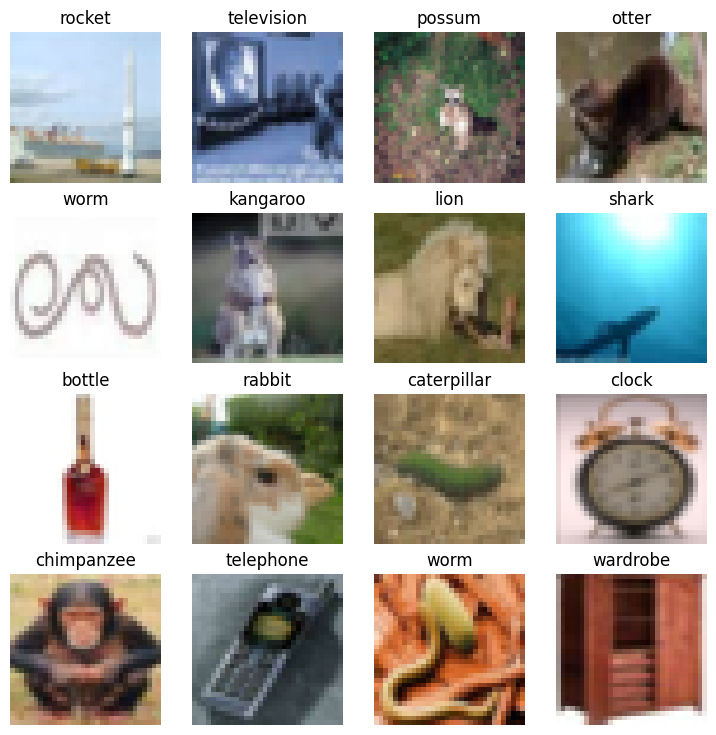

In [7]:
image , label = train_data[0]
print(f"image shape: {image.shape}")

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows ,cols ,i)
    plt.imshow(img.permute(1,2,0).squeeze())
    plt.title(class_names[label])
    plt.axis(False);

In [101]:

#set up the bach size hyper parameter
BATCH_SIZE = 100

# TURN DATA SETS INTO ITERABLES (BATCHES)

train_dataloader = DataLoader(dataset  = train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset  = test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

len(train_dataloader) , len(test_dataloader)

(500, 100)

In [24]:
class TinyVGG(nn.Module):
    """
    Model architecture that replicate the tinyvgg
    model from cnn explaner website.
    """
    def __init__(self, input_shape:int, hidden_units: int , output_shape : int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
        # creat a conv layer
        nn.Conv2d(in_channels= input_shape,
                 out_channels= hidden_units,
                 kernel_size=3,
                 stride = 1,
                 padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels= hidden_units,
                 out_channels= hidden_units,
                 kernel_size=3,
                 stride = 1,
                 padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_2= nn.Sequential(
            nn.Conv2d(in_channels= hidden_units,
                     out_channels= hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels= hidden_units,
                     out_channels= hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2)        
        )
        
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*64,
                     out_features=  output_shape)
        )
        
    def forward(self,x):
        
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
        
        

In [27]:
model_0 = TinyVGG(input_shape=3 , hidden_units=10,output_shape=len(class_names))
# model_2 = TinyVGGV2(input_shape=3 , hidden_units=10,output_shape=len(class_names))
image_batch , label_batch = next(iter(train_dataloader))
image_batch.shape , label_batch.shape
# model_2(image_batch)

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [30]:
summary(model_0 , input_size=[1,3,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 100]                  --
├─Sequential: 1-1                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 10, 32, 32]           280
│    └─ReLU: 2-2                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 10, 32, 32]           910
│    └─ReLU: 2-4                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 10, 16, 16]           --
├─Sequential: 1-2                        [1, 10, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 10, 16, 16]           910
│    └─ReLU: 2-7                         [1, 10, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 10, 16, 16]           910
│    └─ReLU: 2-9                         [1, 10, 16, 16]           --
│    └─MaxPool2d: 2-10                   [1, 10, 8, 8]             --
├─Sequentia

In [103]:
def train_step(model : torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer , ):
    model.train()
    
    train_loss ,train_acc = 0,0
    
    for batch, (x,y) in enumerate(dataloader):
        x,y = x.to(device),y.to(device)
        y_pred = model(x)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        
        loss.backward()
        
        optimizer.step()
        
        
        
        y_pred_class = torch.argmax(torch.softmax(y_pred ,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        

    train_loss = train_loss/ len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss ,train_acc



def test_step(model : torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    model.eval()
    
    test_loss , test_acc = 0,0
    
    with torch.inference_mode():
        
        for batch,(x,y) in enumerate(dataloader):
            x,y = x.to(device),y.to(device)
            
            test_pred_logits = model(x)
            
            loss = loss_fn(test_pred_logits , y)
            test_loss += loss.item()
            
            test_pred_labels  =  test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc /len(dataloader)
        return test_loss , test_acc

    
    

def train(model_name: str ,
    model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
         
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # create an empty result dictionary
    results = {"train_loss" : [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}
    max_acc = 0
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader=train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer )
        
        test_loss, test_acc = test_step(model = model,
                                           dataloader=test_dataloader,
                                           loss_fn = loss_fn)
        
        
         # print whats happening
        print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Train acc: {train_acc: .4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc: .4f} ")
        
        
        
        if test_acc > max_acc:
            #1.create models directory
            MODEL_PATH =  Path("models")
            MODEL_PATH.mkdir(parents=True, exist_ok=True)

            # 2. creat model save path
            MODEL_NAME = f"{model_name}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

            #save the model stat dict
            print(f"saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
            max_acc = test_acc
            
        
       
        # update result dic
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results
    
        


In [51]:
NUM_EPOCHS = 200

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr = 0.001)

from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model_name="tiny_vgg_w_s",model= model_0,
                       train_dataloader=  train_dataloader,
                       test_dataloader= test_dataloader,
                       optimizer = optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS)
end_time = timer()
print(f"total training time for model_0: {end_time - start_time:.3f} seconds")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  2.1966 | Train acc:  0.4410 | Test loss:  2.6185 | Test acc:  0.3599 
saving model to: models\tiny_vgg_w_s.pth
Epoch: 1 | Train loss:  2.1790 | Train acc:  0.4434 | Test loss:  2.6139 | Test acc:  0.3603 
saving model to: models\tiny_vgg_w_s.pth
Epoch: 2 | Train loss:  2.1820 | Train acc:  0.4435 | Test loss:  2.5983 | Test acc:  0.3636 
saving model to: models\tiny_vgg_w_s.pth
Epoch: 3 | Train loss:  2.1636 | Train acc:  0.4464 | Test loss:  2.6582 | Test acc:  0.3472 
Epoch: 4 | Train loss:  2.1610 | Train acc:  0.4479 | Test loss:  2.5913 | Test acc:  0.3626 
Epoch: 5 | Train loss:  2.1569 | Train acc:  0.4491 | Test loss:  2.6078 | Test acc:  0.3609 
Epoch: 6 | Train loss:  2.1541 | Train acc:  0.4519 | Test loss:  2.5870 | Test acc:  0.3672 
saving model to: models\tiny_vgg_w_s.pth
Epoch: 7 | Train loss:  2.1399 | Train acc:  0.4529 | Test loss:  2.6148 | Test acc:  0.3611 
Epoch: 8 | Train loss:  2.1366 | Train acc:  0.4528 | Test loss:  2.6367 | Test acc:

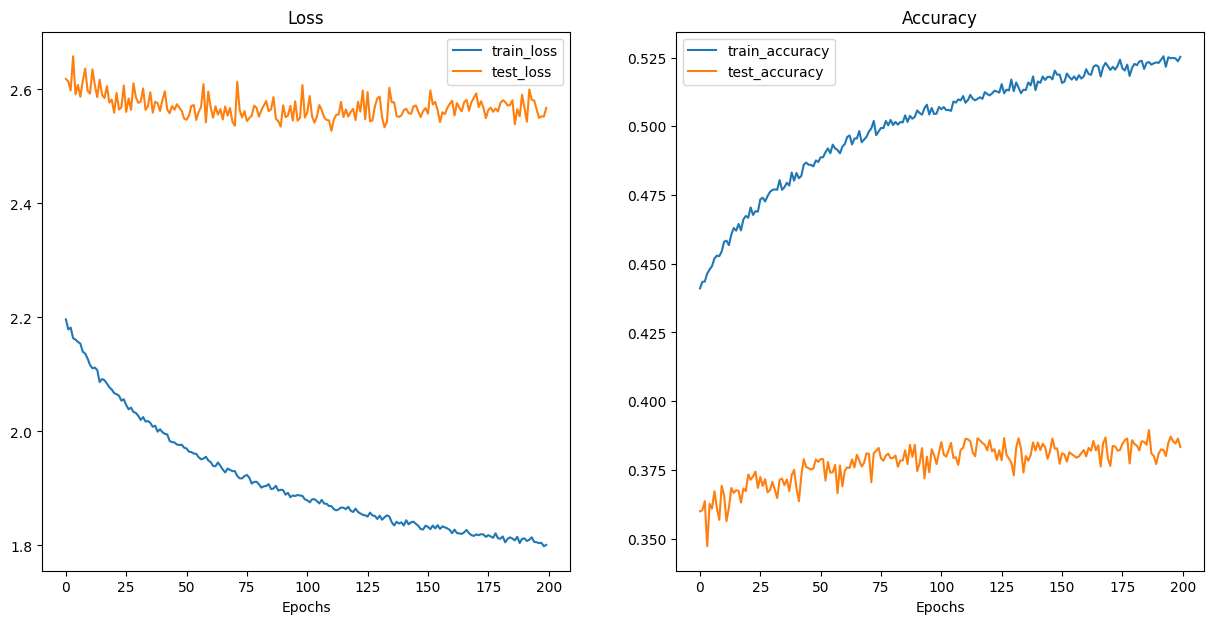

In [73]:
plot_loss_curves(model_0_results)

In [82]:

# random.seed(42)
test_samples = []
test_labels = []
for sample , label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)
    
def make_predictions(model: torch.nn.Module,
                    data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.to(device)
            # prepare the sample
            sample = torch.unsqueeze(sample , dim=0 )
            
            #forward pass
            pred_logit = model(sample)
            
            #get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            
            pred_probs.append(pred_prob)
            
            
    return torch.stack(pred_probs)

pred_probs = make_predictions(model=model_0,
                              data= test_samples)
pred_classes = pred_probs.argmax(dim=1)
# plot pred
plt.figure(figsize= (9,9))
nrows = 3
ncols = 3
for i , sample in enumerate(test_samples):
    
    plt.subplot(nrows , ncols , i+1)
    
    plt.imshow(sample.permute(1,2,0).squeeze())
    
    pred_label = class_names[pred_classes[i]]
    
    truth_label = class_names[test_labels[i]]
    
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    if pred_label ==  truth_label:
        plt.title(title_text , fontsize = 10,c = "g")
    else:
        plt.title(title_text , fontsize = 10,c = "r")
    plt.axis(False)

NameError: name 'model_0' is not defined

making predictions...:   0%|          | 0/100 [00:00<?, ?it/s]

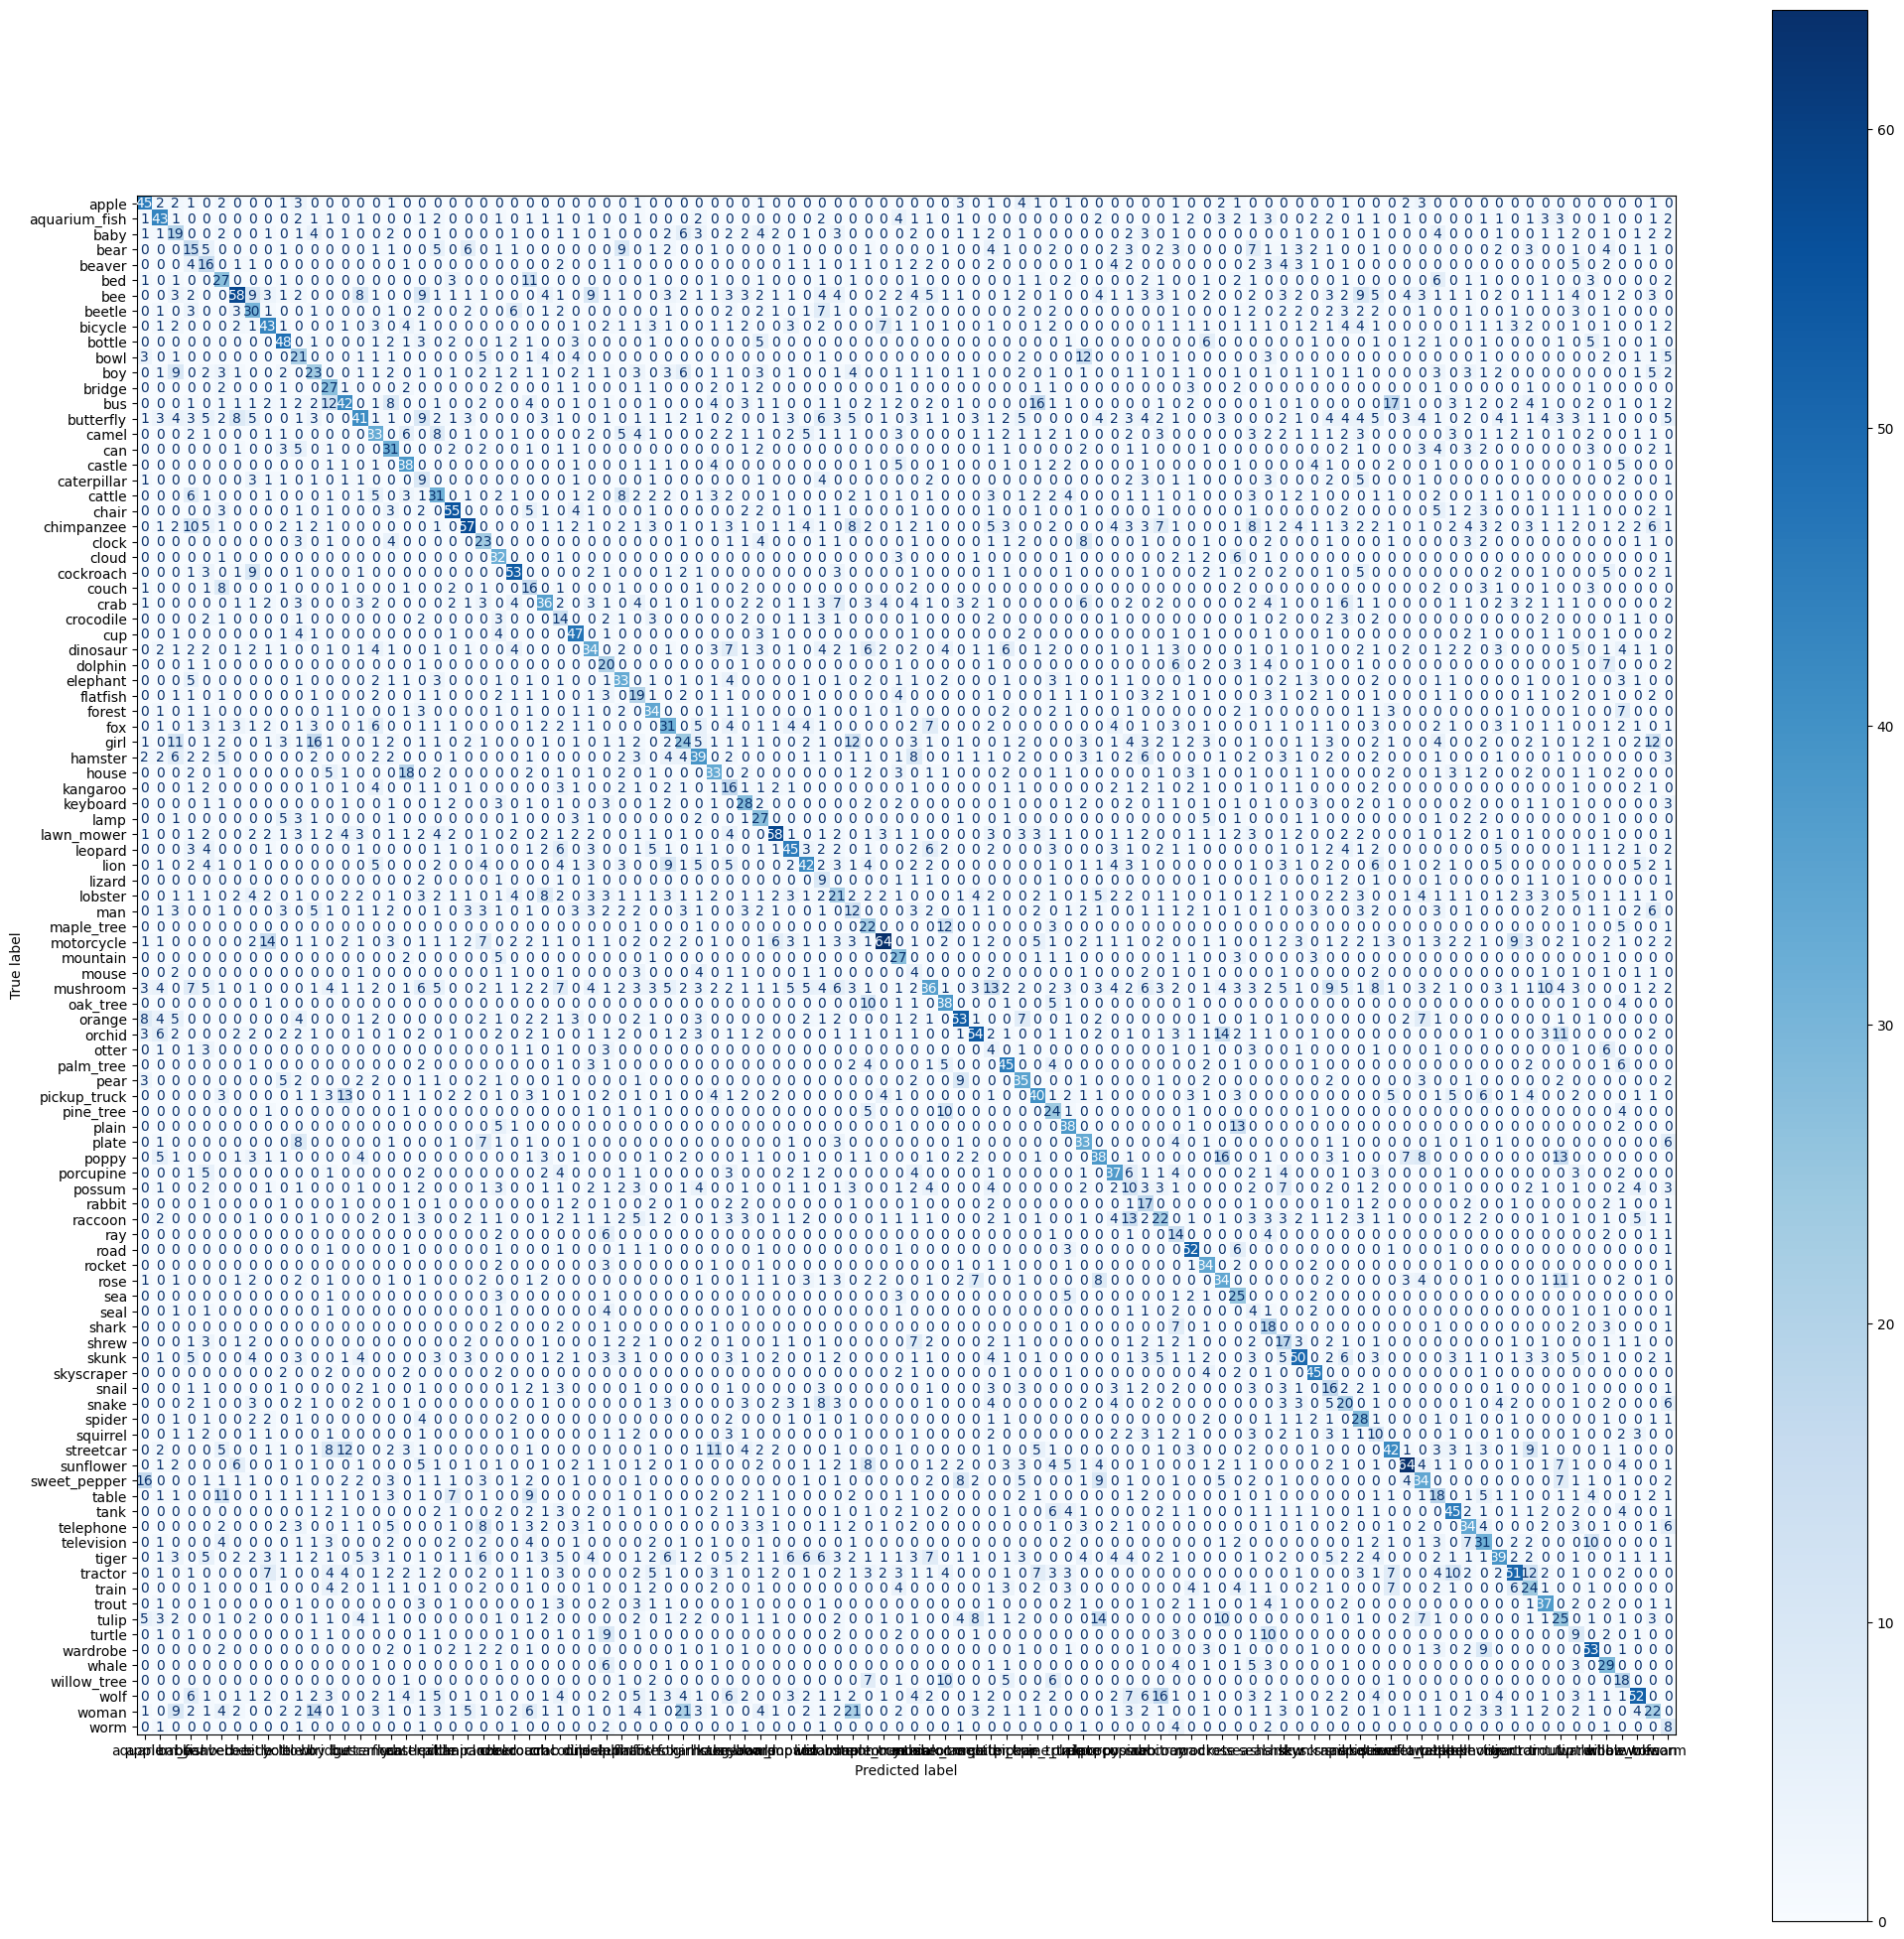

In [91]:

y_preds = []
x_test = []
model_0.eval()
with torch.inference_mode():
    for x,y in tqdm(test_dataloader,desc = "making predictions..."):
        x,y = x.to(device),y.to(device)
        y_logit = model_0(x)
        
        y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
        
        y_preds.append(y_pred.to('cpu'))
        x_test.append(y.to('cpu'))
        
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
x_test_cat = torch.cat(x_test)
cm = confusion_matrix(y_pred_tensor,x_test_cat)
disp = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots(figsize=(25,25))
disp.plot(ax=ax ,cmap=plt.cm.Blues)

In [ ]:
model_0 = TinyVGG(input_shape=3 , hidden_units=10,output_shape=len(class_names))

model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# tinny with normalize and sch

In [3]:
# set up training data
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
data_transform_train = transforms.Compose([
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)
])

data_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

train_data = datasets.CIFAR100(root="Tdata",train=True,download=True,
                                  transform = data_transform_train,
                                  target_transform = None)

test_data = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  transform =data_transform_test,
                                  target_transform = None)

test_data_normal = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  target_transform = None)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
image , label = train_data[0]
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

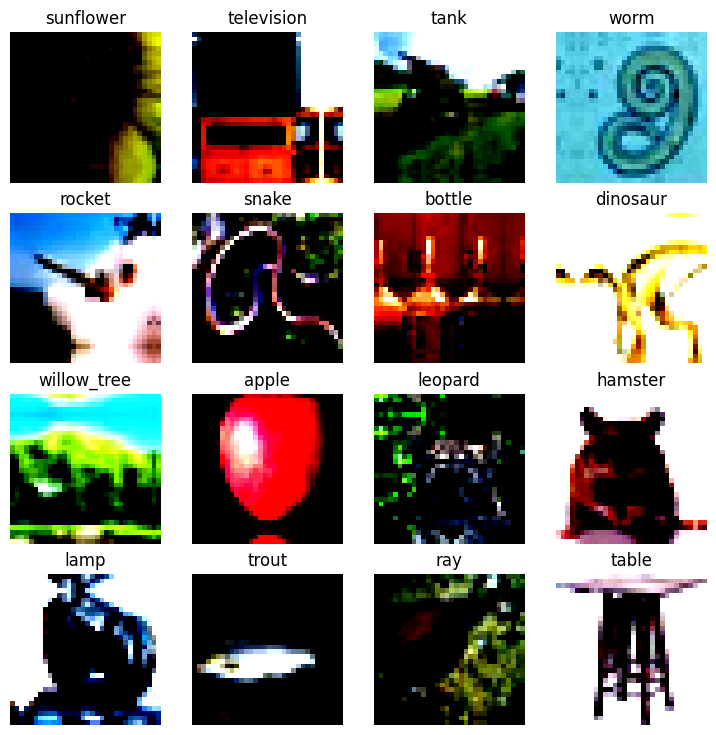

In [7]:
image , label = train_data[0]
print(f"image shape: {image.shape}")

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows ,cols ,i)
    plt.imshow(img.permute(1,2,0).squeeze())
    plt.title(class_names[label])
    plt.axis(False);

In [9]:
def train_step(model : torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer , scheduler):
    model.train()
    
    train_loss ,train_acc = 0,0
    
    for batch, (x,y) in enumerate(dataloader):
        x,y = x.to(device),y.to(device)
        y_pred = model(x)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        
        loss.backward()
        
        optimizer.step()
        
        
        
        y_pred_class = torch.argmax(torch.softmax(y_pred ,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        
    scheduler.step()   
    train_loss = train_loss/ len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss ,train_acc



def test_step(model : torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    model.eval()
    
    test_loss , test_acc = 0,0
    
    with torch.inference_mode():
        
        for batch,(x,y) in enumerate(dataloader):
            x,y = x.to(device),y.to(device)
            
            test_pred_logits = model(x)
            
            loss = loss_fn(test_pred_logits , y)
            test_loss += loss.item()
            
            test_pred_labels  =  test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc /len(dataloader)
        return test_loss , test_acc

    
    

def train(model_name: str ,
    model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # create an empty result dictionary
    results = {"train_loss" : [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}
    max_acc = 0
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader=train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer , scheduler=scheduler)
        
        test_loss, test_acc = test_step(model = model,
                                           dataloader=test_dataloader,
                                           loss_fn = loss_fn)
        
        
         # print whats happening
        print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Train acc: {train_acc: .4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc: .4f} ")
        
        
        
        if test_acc > max_acc:
            #1.create models directory
            MODEL_PATH =  Path("models")
            MODEL_PATH.mkdir(parents=True, exist_ok=True)

            # 2. creat model save path
            MODEL_NAME = f"{model_name}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

            #save the model stat dict
            print(f"saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
            max_acc = test_acc
            
        
       
        # update result dic
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results
    
        


In [11]:

#set up the bach size hyper parameter
BATCH_SIZE = 100

# TURN DATA SETS INTO ITERABLES (BATCHES)

train_dataloader = DataLoader(dataset  = train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset  = test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

len(train_dataloader) , len(test_dataloader)

(500, 100)

In [105]:
model_1 = TinyVGG(input_shape=3 , hidden_units=10,output_shape=len(class_names))
# model_2 = TinyVGGV2(input_shape=3 , hidden_units=10,output_shape=len(class_names))
image_batch , label_batch = next(iter(train_dataloader))
image_batch.shape , label_batch.shape

# model_2(image_batch)

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [118]:
NUM_EPOCHS = 10



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr = 0.01)
scheduler =  torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.01, epochs=NUM_EPOCHS, 
                                                steps_per_epoch=len(train_dataloader))



from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model_name="tiny_vgg_withN_and_sch",model= model_0,
                       train_dataloader=  train_dataloader,
                       test_dataloader= test_dataloader,
                       optimizer = optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       scheduler=scheduler)
end_time = timer()
print(f"total training time for model_0: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  10.3197 | Train acc:  0.1329 | Test loss:  9.8735 | Test acc:  0.1673 
saving model to: models\tiny_vgg_withN_and_sch.pth
Epoch: 1 | Train loss:  10.2897 | Train acc:  0.1343 | Test loss:  9.8735 | Test acc:  0.1673 
Epoch: 2 | Train loss:  10.3156 | Train acc:  0.1328 | Test loss:  9.8735 | Test acc:  0.1673 
Epoch: 3 | Train loss:  10.3272 | Train acc:  0.1323 | Test loss:  9.8735 | Test acc:  0.1673 
Epoch: 4 | Train loss:  10.3240 | Train acc:  0.1333 | Test loss:  9.8735 | Test acc:  0.1673 
Epoch: 5 | Train loss:  10.3240 | Train acc:  0.1329 | Test loss:  9.8735 | Test acc:  0.1673 
Epoch: 6 | Train loss:  10.3292 | Train acc:  0.1317 | Test loss:  9.8735 | Test acc:  0.1673 
Epoch: 7 | Train loss:  10.3251 | Train acc:  0.1321 | Test loss:  9.8735 | Test acc:  0.1673 
Epoch: 8 | Train loss:  10.2914 | Train acc:  0.1350 | Test loss:  9.8735 | Test acc:  0.1673 
Epoch: 9 | Train loss:  10.2972 | Train acc:  0.1308 | Test loss:  9.8735 | Test acc:  0.1673 

# ResNet

In [117]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
# set up training data
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
data_transform_train = transforms.Compose([
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)
])

data_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

train_data = datasets.CIFAR100(root="Tdata",train=True,download=True,
                                  transform = data_transform_train,
                                  target_transform = None)

test_data = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  transform =data_transform_test,
                                  target_transform = None)

test_data_normal = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  target_transform = None)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:
# PyTorch data loaders
train_dl = DataLoader(train_data, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(test_data, BATCH_SIZE*2, num_workers=3, pin_memory=True)

In [17]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


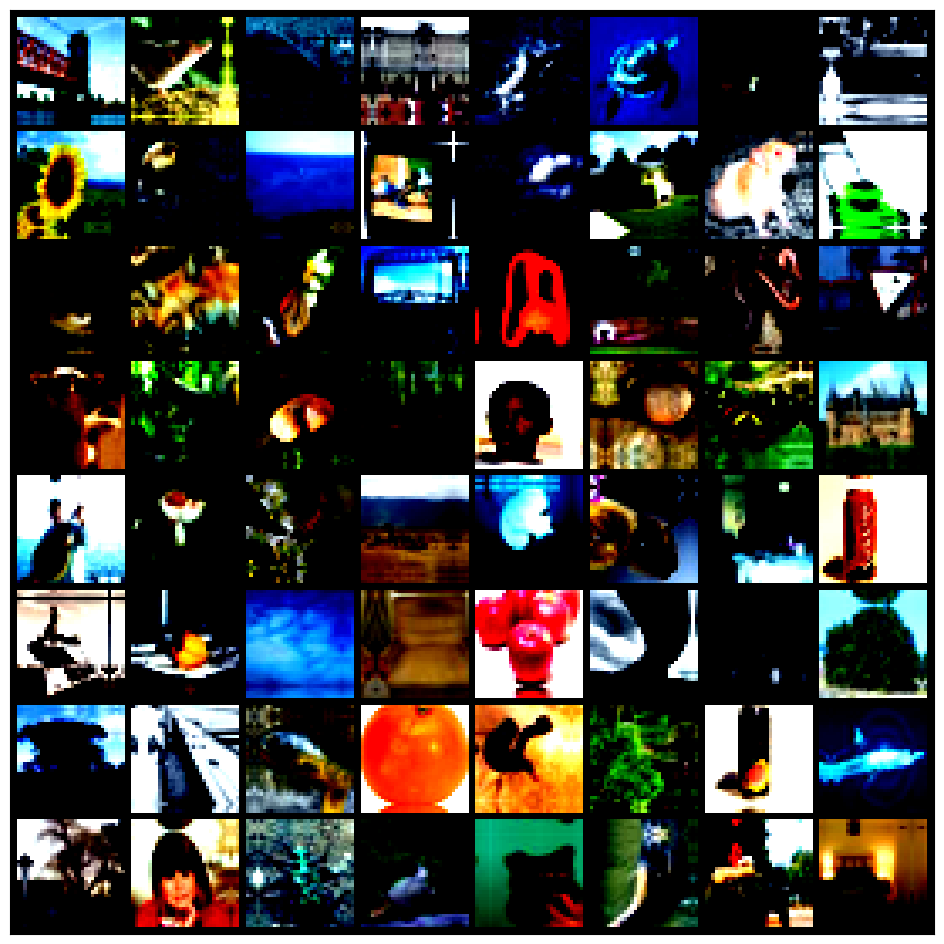

In [19]:
show_batch(train_dl)

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()

In [39]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [41]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [43]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([100, 3, 32, 32])


In [45]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        

        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [47]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [49]:
model_2 = to_device(ResNet9(3, 100), device)
summary(model_2)

Layer (type:depth-idx)                   Param #
ResNet9                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       73,856
│    └─BatchNorm2d: 2-5                  256
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
│    └─Sequential: 2-8                   --
│    │    └─Conv2d: 3-1                  147,584
│    │    └─BatchNorm2d: 3-2             256
│    │    └─ReLU: 3-3                    --
│    └─Sequential: 2-9                   --
│    │    └─Conv2d: 3-4                  147,584
│    │    └─BatchNorm2d: 3-5             256
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-10                      295,168
│

In [51]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [53]:
history = [evaluate(model_2, valid_dl)]
history

[{'val_loss': 4.606472015380859, 'val_acc': 0.010899999178946018}]

In [56]:
epochs = 30
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [58]:
%%time
history += fit_one_cycle(epochs, max_lr, model_2, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00069, train_loss: 3.4372, val_loss: 3.0103, val_acc: 0.2663
Epoch [1], last_lr: 0.00152, train_loss: 2.6131, val_loss: 2.8311, val_acc: 0.3348
Epoch [2], last_lr: 0.00280, train_loss: 2.3313, val_loss: 2.7113, val_acc: 0.3566
Epoch [3], last_lr: 0.00436, train_loss: 2.0598, val_loss: 2.2169, val_acc: 0.4235
Epoch [4], last_lr: 0.00603, train_loss: 1.8563, val_loss: 2.3921, val_acc: 0.3990
Epoch [5], last_lr: 0.00760, train_loss: 1.8018, val_loss: 2.6623, val_acc: 0.3797
Epoch [6], last_lr: 0.00888, train_loss: 1.7983, val_loss: 2.1700, val_acc: 0.4402
Epoch [7], last_lr: 0.00971, train_loss: 1.8053, val_loss: 2.0805, val_acc: 0.4495
Epoch [8], last_lr: 0.01000, train_loss: 1.8099, val_loss: 2.2254, val_acc: 0.4341
Epoch [9], last_lr: 0.00994, train_loss: 1.7996, val_loss: 2.1572, val_acc: 0.4402
Epoch [10], last_lr: 0.00978, train_loss: 1.7795, val_loss: 2.0074, val_acc: 0.4655
Epoch [11], last_lr: 0.00950, train_loss: 1.7499, val_loss: 2.1559, val_acc: 0.4482
Ep

In [61]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

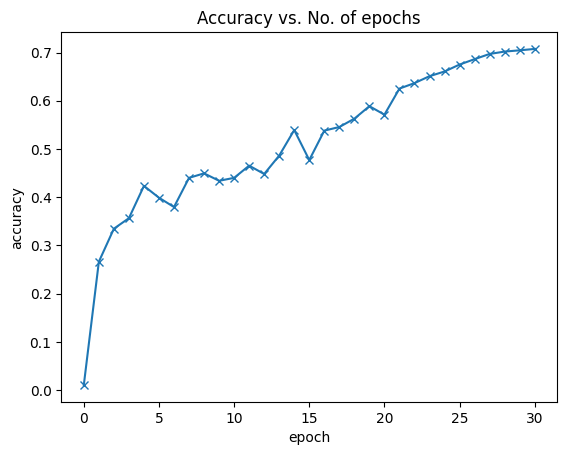

In [64]:
plot_accuracies(history)

In [67]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

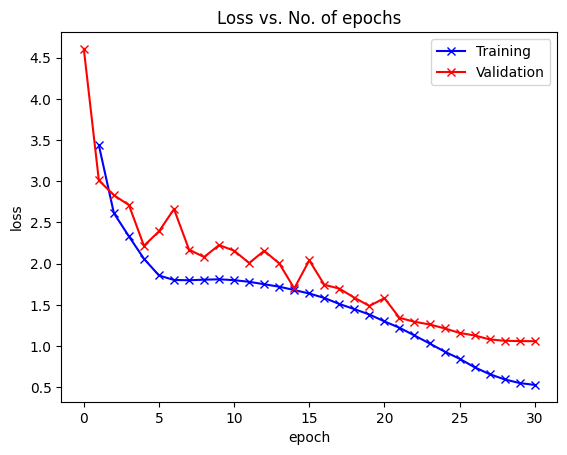

In [70]:
plot_losses(history)

In [73]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

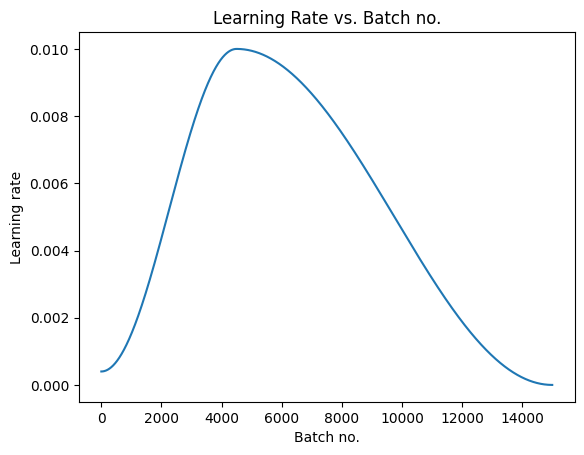

In [76]:
plot_lrs(history)

In [79]:
#1.create models directory
MODEL_PATH =  Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. creat model save path
MODEL_NAME = "01_ResNet_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#save the model stat dict
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

saving model to: models\01_ResNet_model_1.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


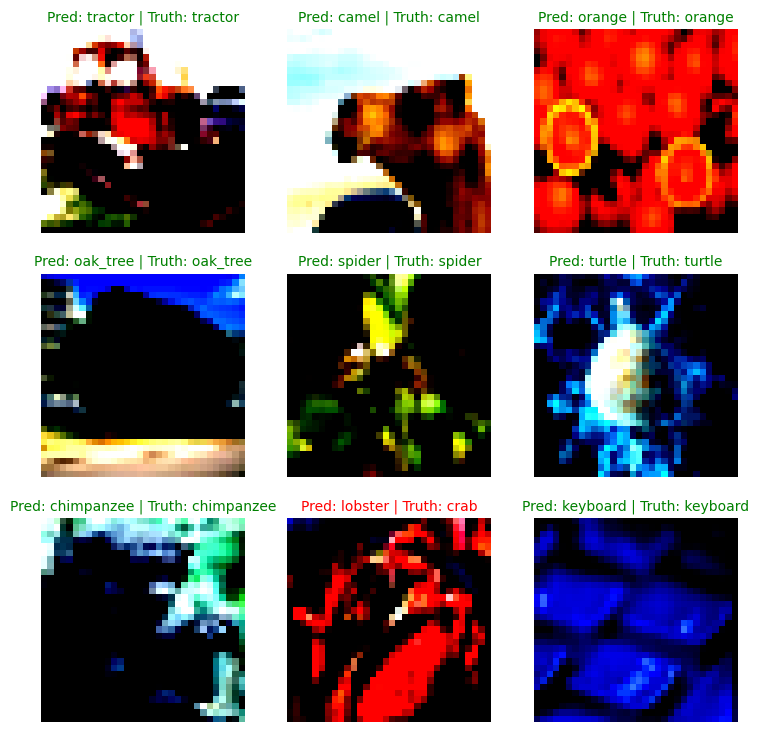

In [86]:

# random.seed(42)
test_samples = []
test_labels = []
for sample , label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)
    
def make_predictions(model: torch.nn.Module,
                    data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.to(device)
            # prepare the sample
            sample = torch.unsqueeze(sample , dim=0 )
            
            #forward pass
            pred_logit = model(sample)
            
            #get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            
            pred_probs.append(pred_prob)
            
            
    return torch.stack(pred_probs)

pred_probs = make_predictions(model=model_2,
                              data= test_samples)
pred_classes = pred_probs.argmax(dim=1)
# plot pred
plt.figure(figsize= (9,9))
nrows = 3
ncols = 3
for i , sample in enumerate(test_samples):
    
    plt.subplot(nrows , ncols , i+1)
    
    plt.imshow(sample.permute(1,2,0).squeeze())
    
    pred_label = class_names[pred_classes[i]]
    
    truth_label = class_names[test_labels[i]]
    
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    if pred_label ==  truth_label:
        plt.title(title_text , fontsize = 10,c = "g")
    else:
        plt.title(title_text , fontsize = 10,c = "r")
    plt.axis(False)

# model 3

In [141]:
# set up training data
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
data_transform_train = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)
])

data_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

train_data = datasets.CIFAR100(root="Tdata",train=True,download=True,
                                  transform = data_transform_train,
                                  target_transform = None)

test_data = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  transform =data_transform_test,
                                  target_transform = None)

test_data_normal = datasets.CIFAR100(root="Tdata",train=False,download=True,
                                  target_transform = None)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [142]:
# PyTorch data loaders
train_dl = DataLoader(train_data, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(test_data, BATCH_SIZE*2, num_workers=3, pin_memory=True)

In [145]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()

In [147]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [149]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [151]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([100, 3, 32, 32])


In [152]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        

        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [133]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [135]:
model_3 = to_device(ResNet9(3, 100), device)
summary(model_3)

Layer (type:depth-idx)                   Param #
ResNet9                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       73,856
│    └─BatchNorm2d: 2-5                  256
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
│    └─Sequential: 2-8                   --
│    │    └─Conv2d: 3-1                  147,584
│    │    └─BatchNorm2d: 3-2             256
│    │    └─ReLU: 3-3                    --
│    └─Sequential: 2-9                   --
│    │    └─Conv2d: 3-4                  147,584
│    │    └─BatchNorm2d: 3-5             256
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-10                      295,168
│

In [137]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [139]:
history = [evaluate(model_3, valid_dl)]
history

[{'val_loss': 4.607418060302734, 'val_acc': 0.010099999606609344}]

In [ ]:
epochs = 30
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model_3, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)